In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import sklearn
import pandas as pd
import os
import sys
import time
import tensorflow as tf

from tensorflow import keras

print(tf.__version__)
print(sys.version_info)
for module in mpl, np, pd, sklearn, tf, keras:
    print(module.__name__, module.__version__)


2.2.0
sys.version_info(major=3, minor=6, micro=9, releaselevel='final', serial=0)
matplotlib 3.2.1
numpy 1.18.5
pandas 1.0.4
sklearn 0.23.1
tensorflow 2.2.0
tensorflow.keras 2.3.0-tf


In [2]:
#在这个库中，tf帮我们定义很多数据集，这些数据集是以dataset来存储的
# https://tensorflow.google.cn/datasets/catalog/overview
import tensorflow_datasets as tfds

#仍然是电影的二分类问题
#我们可以到数据集中去看imdb_reviews/subwords8k的信息
# with_info if True, tfds.load will return the tuple (tf.data.Dataset, tfds.core.DatasetInfo) 
# containing the info associated with the builder.
dataset, info = tfds.load('imdb_reviews/subwords8k', with_info = True,
                          #as_supervised代表有监督的，会把labels，也就是结果返回
                          as_supervised=True)

train_dataset, test_dataset = dataset['train'], dataset['test']

In [3]:
#通过encoder把我们的词语转换为subword形式
tokenizer = info.features['text'].encoder
print('vocabulary size: {}'.format(tokenizer.vocab_size))

vocabulary size: 8185


In [17]:
for i in train_dataset.take(1):
    print(np.array(i[0]))
    print(tokenizer.decode(np.array(i[0])))

[  62   18   41  604  927   65    3  644 7968   21   35 5096   36   11
   43 2948 5240  102   50  681 7862 1244    3 3266   29  122  640    2
   26   14  279  438   35   79  349  384   11 1991    3  492   79  122
  188  117   33 4047 4531   14   65 7968    8 1819 3947    3   62   27
    9   41  577 5044 2629 2552 7193 7961 3642    3   19  107 3903  225
   85  198   72    1 1512  738 2347  102 6245    8   85  308   79 6936
 7961   23 4981 8044    3 6429 7961 1141 1335 1848 4848   55 3601 4217
 8050    2    5   59 3831 1484 8040 7974  174 5773   22 5240  102   18
  247   26    4 3903 1612 3902  291   11    4   27   13   18 4092 4008
 7961    6  119  213 2774    3   12  258 2306   13   91   29  171   52
  229    2 1245 5790  995 7968    8   52 2948 5240 8039 7968    8   74
 1249    3   12  117 2438 1369  192   39 7975]
This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in histo

In [5]:
sample_string = 'Tensorflow is cool.'
#encode是变为id序列
tokenized_string = tokenizer.encode(sample_string)
print('Tokenized string is {}'.format(tokenized_string))
print(type(tokenized_string))
#decode又变为原来的字符串
original_string = tokenizer.decode(tokenized_string)
print('Original string is {}'.format(original_string))

assert original_string == sample_string

Tokenized string is [6307, 2327, 2934, 7961, 9, 2724, 7975]
<class 'list'>
Original string is Tensorflow is cool.


In [6]:
#for循环看下每个id
for token in tokenized_string:
    print('{} --> {}'.format(token, tokenizer.decode([token])))

6307 --> Ten
2327 --> sor
2934 --> flow
7961 -->  
9 --> is 
2724 --> cool
7975 --> .


In [7]:
buffer_size = 10000
batch_size = 64

#下面的代码是2.0版本的，已废弃
# print(train_dataset.output_shapes)
# print(test_dataset.output_shapes)

# train_dataset = train_dataset.shuffle(buffer_size)
# train_dataset = train_dataset.padded_batch(batch_size, train_dataset.output_shapes)
# test_dataset = test_dataset.padded_batch(batch_size, test_dataset.output_shapes)

padded_shapes=tf.compat.v1.data.get_output_shapes(train_dataset)

padded_shapes_test=tf.compat.v1.data.get_output_shapes(test_dataset)

print(padded_shapes)

print(padded_shapes_test)

train_dataset = train_dataset.shuffle(buffer_size)
 # padded_batch是每批数据分别做padding
train_dataset = train_dataset.padded_batch(batch_size,padded_shapes) 

test_dataset = test_dataset.padded_batch(batch_size,padded_shapes_test)

(TensorShape([None]), TensorShape([]))
(TensorShape([None]), TensorShape([]))


In [8]:
vocab_size = tokenizer.vocab_size
embedding_dim = 16
batch_size = 512

bi_rnn_model = keras.models.Sequential([
    keras.layers.Embedding(vocab_size, embedding_dim),
    keras.layers.Bidirectional(
        keras.layers.LSTM(
            units = 32, return_sequences = False)),
    keras.layers.Dense(32, activation = 'relu'),
    keras.layers.Dense(1, activation='sigmoid'),
])

bi_rnn_model.summary()
bi_rnn_model.compile(optimizer = 'adam',
                     loss = 'binary_crossentropy',
                     metrics = ['accuracy'])


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 16)          130960    
_________________________________________________________________
bidirectional (Bidirectional (None, 64)                12544     
_________________________________________________________________
dense (Dense)                (None, 32)                2080      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 33        
Total params: 145,617
Trainable params: 145,617
Non-trainable params: 0
_________________________________________________________________


In [11]:
history = bi_rnn_model.fit(
    train_dataset,
    #因为之前30次过拟合，这里改为10次
    epochs = 10,
    validation_data = test_dataset)

Epoch 1/10
391/391 [==============================] - 529s 1s/step - loss: 0.5073 - accuracy: 0.7508 - val_loss: 0.5740 - val_accuracy: 0.7057
Epoch 2/10
391/391 [==============================] - 483s 1s/step - loss: 0.3590 - accuracy: 0.8517 - val_loss: 0.3857 - val_accuracy: 0.8536
Epoch 3/10
391/391 [==============================] - 430s 1s/step - loss: 0.2715 - accuracy: 0.8990 - val_loss: 0.3695 - val_accuracy: 0.8482
Epoch 4/10
391/391 [==============================] - 303s 774ms/step - loss: 0.2387 - accuracy: 0.9129 - val_loss: 0.4242 - val_accuracy: 0.8275
Epoch 5/10
391/391 [==============================] - 288s 738ms/step - loss: 0.2097 - accuracy: 0.9232 - val_loss: 0.4363 - val_accuracy: 0.8540
Epoch 6/10
391/391 [==============================] - 328s 839ms/step - loss: 0.1721 - accuracy: 0.9417 - val_loss: 0.4288 - val_accuracy: 0.8411
Epoch 7/10
391/391 [==============================] - 300s 766ms/step - loss: 0.1654 - accuracy: 0.9416 - val_loss: 0.5488 - val_accu

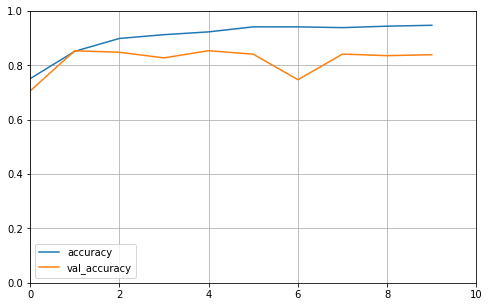

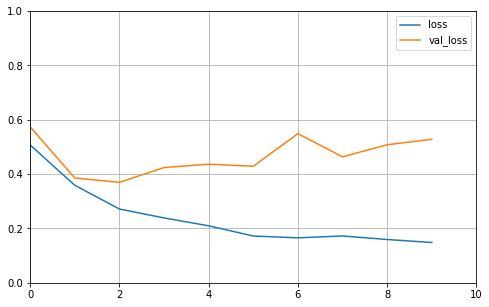

In [12]:
def plot_learning_curves(history, label, epochs, min_value, max_value):
    data = {}
    data[label] = history.history[label]
    data['val_'+label] = history.history['val_'+label]
    pd.DataFrame(data).plot(figsize=(8, 5))
    plt.grid(True)
    plt.axis([0, epochs, min_value, max_value])
    plt.show()
    
plot_learning_curves(history, 'accuracy', 10, 0, 1)
plot_learning_curves(history, 'loss', 10, 0, 1)
#过拟合现象相对之前弱一些

In [13]:
bi_rnn_model.evaluate(test_dataset)

391/391 [==============================] - 47s 121ms/step - loss: 0.5278 - accuracy: 0.8393


[0.527801513671875, 0.8392800092697144]